In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [5]:
#['dDateTime', 'dCode', 'dClose', 'dOpen', 'dHighest', 'dLowest', 'dVolume']
def readTrain():
    train = pd.read_csv('TXF20112015_original.csv')
    return train

# read SPY.csv
train = readTrain()
del train['dCode']
del train['dDateTime']
del train['dVolume']

In [6]:
print(train)

        dClose  dOpen  dHighest  dLowest
0         9004   9000      9007     8998
1         9003   9004      9005     9002
2         9009   9003      9009     9003
3         9008   9009      9010     9005
4         9012   9008      9015     9008
5         9012   9012      9015     9008
6         9016   9012      9017     9011
7         9018   9016      9019     9015
8         9014   9018      9019     9014
9         9015   9014      9016     9014
10        9016   9015      9017     9015
11        9016   9016      9018     9016
12        9014   9016      9017     9013
13        9016   9014      9016     9014
14        9016   9016      9016     9014
15        9021   9016      9022     9014
16        9023   9021      9029     9020
17        9018   9023      9024     9016
18        9017   9018      9018     9014
19        9016   9017      9017     9014
20        9016   9016      9019     9015
21        9017   9016      9020     9015
22        9020   9017      9021     9017
23        9021  

In [17]:
# def augFeatures(train):
#     train["year"] = train["dDateTime"]//100000000
#     train["month"] = (train["dDateTime"]%100000000)//1000000
#     train["date"] = (train["dDateTime"]%1000000)//10000
#     train["hour"] = (train["dDateTime"]%10000)//100
#     train["min"] = train["dDateTime"]%100
#     return train

# Augment the features (year, month, date, day)
# train_Aug = augFeatures(train)

In [9]:
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return train_norm

# Normalization
train_norm = normalize(train)

In [11]:
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["dClose"]))
    return np.array(X_train), np.array(Y_train)

# build Data, use last 30 days to predict next 1 days
X_train, Y_train = buildTrain(train_norm, 30, 1)

In [38]:
def shuffle(X,Y):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

# shuffle the data, and random seed is 10
# X_train, Y_train = shuffle(X_train, Y_train)

In [14]:
def splitData(X,Y,rate):
    #0.2-0.8 train
    X_train = X[int(X.shape[0]*rate):int(X.shape[0]*rate*4)]
    Y_train = Y[int(Y.shape[0]*rate):int(Y.shape[0]*rate*4)]
    #0-0.2 validation
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    #0.8-1 test
    X_test = X[int(X.shape[0]*rate*4):]
    Y_test = Y[int(Y.shape[0]*rate*4):]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

# split training data and validation data
X_train, Y_train, X_val, Y_val, X_test, Y_test = splitData(X_train, Y_train, 0.2)

In [72]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
#     model.add(LeakyReLU(alpha=0.1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [68]:
from keras.models import Sequential  #用來啟動 NN
from keras.layers import Conv2D,Conv1D  # Convolution Operation
from keras.layers import MaxPooling2D,MaxPooling1D # Pooling
from keras.layers import Flatten
from keras.layers import Dense # Fully Connected Networks
from keras.layers import Reshape

In [137]:
# define 1d CNN model
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=32, kernel_size=2, input_shape=(30, 4)))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(1))
model_CNN.add(Dropout(0.5))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 29, 32)            288       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 29, 32)            0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 449       
_________________________________________________________________
dropout_5 (Dropout)          (None, 1)                 0         
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 1)                 0         
Total para

In [135]:
model_CNN.compile(optimizer='adam', loss='mse')
# fit model
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history_CNN = model_CNN.fit(X_train, Y_train, epochs=3000, batch_size=512, validation_data=(X_val, Y_val), verbose=1,callbacks=[callback])

Train on 132829 samples, validate on 44276 samples
Epoch 1/3000
132829/132829 [==============================] - 2s 15us/step - loss: 0.0055 - val_loss: 3.4896e-05
Epoch 2/3000
132829/132829 [==============================] - 1s 4us/step - loss: 1.2338e-05 - val_loss: 2.3232e-05
Epoch 3/3000
132829/132829 [==============================] - 1s 4us/step - loss: 1.1772e-05 - val_loss: 2.2946e-05
Epoch 4/3000
132829/132829 [==============================] - 1s 4us/step - loss: 1.1631e-05 - val_loss: 2.2683e-05
Epoch 5/3000
132829/132829 [==============================] - 1s 4us/step - loss: 1.1488e-05 - val_loss: 2.2332e-05
Epoch 6/3000
132829/132829 [==============================] - 1s 4us/step - loss: 1.1304e-05 - val_loss: 2.1884e-05
Epoch 7/3000
132829/132829 [==============================] - 1s 4us/step - loss: 1.1098e-05 - val_loss: 2.1414e-05
Epoch 8/3000
132829/132829 [==============================] - 1s 4us/step - loss: 1.0860e-05 - val_loss: 2.0872e-05
Epoch 9/3000
132829/1328

132829/132829 [==============================] - 1s 4us/step - loss: 4.0542e-06 - val_loss: 5.4796e-06
Epoch 71/3000
132829/132829 [==============================] - 1s 4us/step - loss: 3.7982e-06 - val_loss: 5.3630e-06
Epoch 72/3000
132829/132829 [==============================] - 1s 4us/step - loss: 3.9579e-06 - val_loss: 5.1133e-06
Epoch 73/3000
132829/132829 [==============================] - 1s 4us/step - loss: 3.3929e-06 - val_loss: 5.1523e-06
Epoch 74/3000
132829/132829 [==============================] - 1s 4us/step - loss: 3.7737e-06 - val_loss: 5.2382e-06
Epoch 75/3000
132829/132829 [==============================] - 1s 4us/step - loss: 3.5870e-06 - val_loss: 4.9494e-06
Epoch 76/3000
132829/132829 [==============================] - 1s 4us/step - loss: 3.7197e-06 - val_loss: 5.2802e-06
Epoch 77/3000
132829/132829 [==============================] - 1s 4us/step - loss: 3.4067e-06 - val_loss: 6.0453e-06
Epoch 78/3000
132829/132829 [==============================] - 1s 4us/step - l

dict_keys(['val_loss', 'loss'])


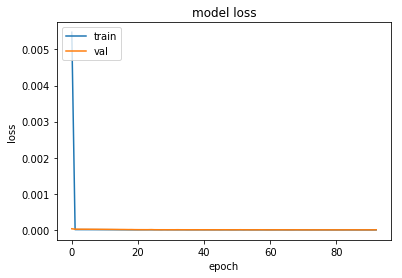

In [138]:
# list all data in history_CNN
print(history_CNN.history.keys())
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [109]:
# demonstrate prediction
# x_input = array([[70,75,145,30], [80,85,165,78], [90,95,185,65]])
# X_test_input = X_test.reshape((1, 30, 4))
PRED_CNN = model_CNN.predict(X_test, verbose=1)
print(PRED_CNN)

44277/44277 [==============================] - 1s 26us/step
[[0.74229836]
 [0.7312723 ]
 [0.69885105]
 ...
 [0.75318515]
 [0.7279138 ]
 [0.7305472 ]]


In [100]:
Y_test = pd.DataFrame(Y_test)

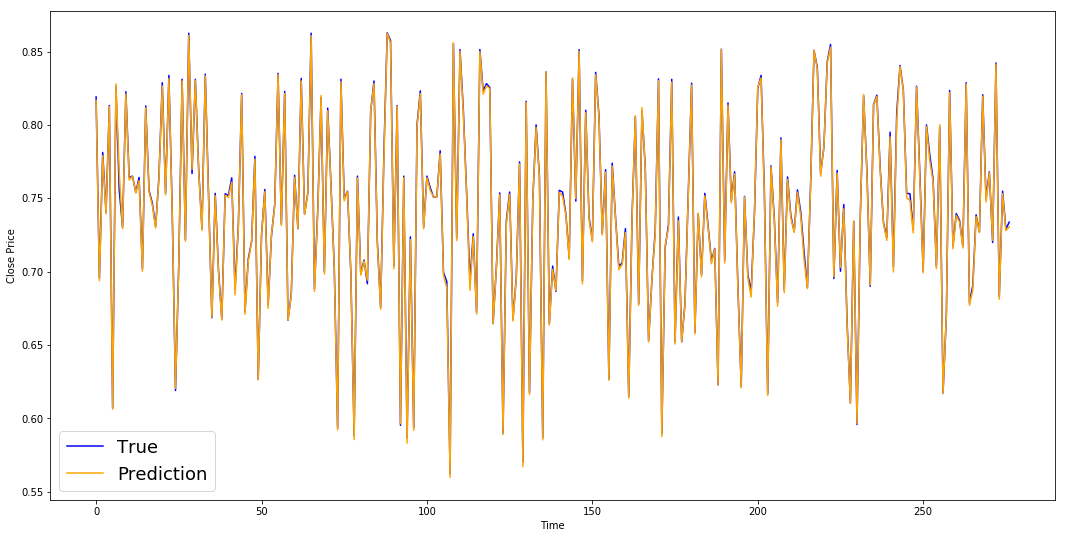

In [110]:
plt.figure(figsize = (18,9))
plt.plot(range(df_Y_test.shape[0]-44000),df_Y_test[44000:],color='b',label='True')
plt.plot(range(np.size(PRED_CNN)-44000),PRED_CNN[44000:],color='orange',label='Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [102]:
#LSTM model
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, epochs=30, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(30, 4))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                600       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________
Train on 132829 samples, validate on 44276 samples
Epoch 1/30
132829/132829 [==============================] - 25s 188us/step - loss: 5.7119e-04 - val_loss: 6.5460e-06
Epoch 2/30
132829/132829 [==============================] - 24s 180us/step - loss: 3.1861e-06 - val_loss: 6.4182e-06
Epoch 3/30
 78464/132829 [================>.............] - ETA: 8s - loss: 3.0419e-06

KeyboardInterrupt: 

In [33]:
# list all data in history
print(history.history.keys())
print(history)

dict_keys(['val_loss', 'loss'])


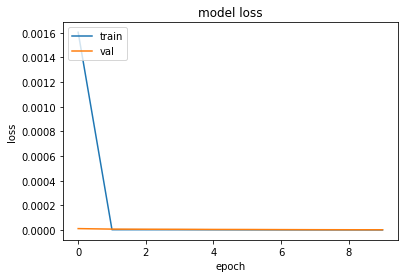

In [46]:
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [35]:
model.save('my_model_04_10.h5')

In [36]:
import tensorflow as tf
model = tf.contrib.keras.models.load_model('my_model_04_10.h5')

In [ ]:
score = model.evaluate(X_val, Y_val, verbose=1)
print(score)

In [40]:
# X_test, Y_test = shuffle(X_test, Y_test)

In [41]:
prediction = model.predict(X_test)

In [43]:
print(prediction)

[[0.7428704 ]
 [0.73165786]
 [0.69852895]
 ...
 [0.75362355]
 [0.7267067 ]
 [0.731146  ]]


In [42]:
df_Y_test = pd.DataFrame(Y_test)

In [ ]:
# prediction_arr = prediction.values

In [25]:
print(range(df_Y_test.shape[0]))

range(0, 44277)


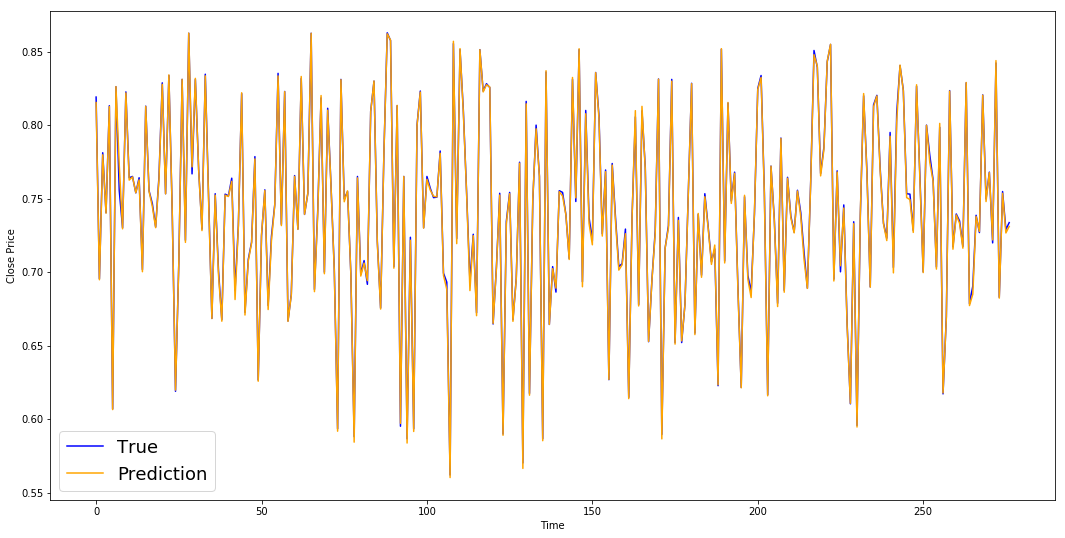

In [95]:
plt.figure(figsize = (18,9))
plt.plot(range(df_Y_test.shape[0]-44000),df_Y_test[44000:],color='b',label='True')
plt.plot(range(np.size(prediction)-44000),prediction[44000:],color='orange',label='Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df_Y_test.shape[0]),df_Y_test,color='b',label='True')
plt.plot(range(np.size(prediction)),prediction,color='orange',label='Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [28]:
w = abs(prediction - df_Y_test)

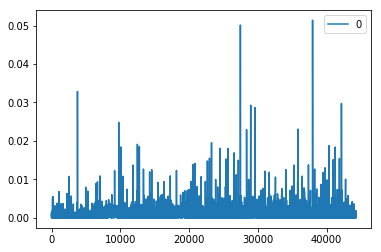

In [29]:
w.plot()

In [ ]:
# DeNormalization
# prediction = pd.DataFrame(prediction)
# predict_norm = denormalize(prediction)
# print(predict_norm)